# **1. Import necessary libraries**

In [1]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers.merge import concatenate
from numpy import argmax
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Necessary Data Cleaning Functions**

In [3]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

In [4]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

In [5]:
def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

# **3. Preprocess the Dataset(Combined corpus of SemEval2017 + Airlines + subset of Sentiment140) for training the Networks**

In [6]:
mega_frame = create_data_corpus('drive/My Drive/SentimentAnalysis/MegaData') #Use this path only (Modify if needed)
mega_frame = clean_tweets(frame=mega_frame, column_name='Column3', remove_stop_words=False, remove_special=False)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...
...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...


# **4. Build the Inputs to our networks**

**One-hot encode the labels**

In [7]:
mega_frame["Sentiment_Value"] = mega_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
labels = to_categorical(mega_frame["Sentiment_Value"], 3)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...,2
...,...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...,1
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...,1
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman,2
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...,2


**Get statistics of our data**

In [8]:
mega_frame['test'] = mega_frame['Tweet_Clean_Text'].apply(lambda x: len(str(x).split()))
print("mean length of sentence: " + str(mega_frame.test.mean()))
print("max length of sentence: " + str(mega_frame.test.max()))
print("std dev length of sentence: " + str(mega_frame.test.std()))

mean length of sentence: 15.85478646097813
max length of sentence: 39
std dev length of sentence: 6.794046007912811


**Vectorize and convert text into sequences**

In [9]:
maxlen = mega_frame.test.max()
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)
  
tokenizer.fit_on_texts(mega_frame['Tweet_Clean_Text'].values)
num_features = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(mega_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=maxlen, padding='post')

print("Vocab size: ", num_features)
print("Input shape: ", X.shape)
print("Labels shape: " , labels.shape)

Vocab size:  73456
Input shape:  (114218, 39)
Labels shape:  (114218, 3)


**Create Training, Validation, and Test Data splits**

In [10]:
#FINAL DATASETS (Please note case sensitivity)- TRAINING: (X_train,Y_train)  VALIDATION: (X_val, Y_val)  TEST: (X_test, Y_test)

Y = labels

x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=1)

# **Model helpers (metrics, callbacks, plots)**

### **Metrics**

In [11]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_metrics'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
]

### **Training Plots**

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

### **Callbacks**

In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, verbose=1)

# **Ensembling Techniques**

## **Stacked Predictions**

In [14]:
# stacked generalization with neural net meta model on blobs dataset

# load models from file
def load_all_models(model_names):
	all_models = list()
	for model_name in model_names:
		# define filename for this ensemble
		filename = '/content/drive/MyDrive/SentimentAnalysis/Models/' + model_name
		# load model from file
		model = load_model(filename,custom_objects={'f1_metrics':f1_metrics,'precision':precision_score,'recall':recall_score})
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# load all models
members = ['LSTM200.h5','LSTM50.h5','LSTM100.h5','LSTM150.h5','LSTM250.h5','FLATCNN[2, 3, 4].h5','FLATCNN[3, 4, 5].h5','FLATCNN[5, 6, 7].h5','FLATCNN[7, 8, 9].h5','FLATCNN[9, 10, 11].h5']
members = load_all_models(members)

members_lstm = members[0:5]
members_cnn = members[5:]

print('Loaded %d models' % len(members))

>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM200.h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM50.h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM100.h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM150.h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM250.h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/FLATCNN[2, 3, 4].h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/FLATCNN[3, 4, 5].h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/FLATCNN[5, 6, 7].h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/FLATCNN[7, 8, 9].h5
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/FLATCNN[9, 10, 11].h5
Loaded 10 models


In [15]:
for i, model in enumerate(members):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
  if i<5: 
    print("\nLSTM_Model_{0}".format(i+1))
  else:
    print("\nCNN_Model_{0}".format(i-4))
    
  model.evaluate(X_test, Y_test, batch_size=1000)



LSTM_Model_1
12/12 [==============================] - 5s 52ms/step - loss: 0.6433 - categorical_accuracy: 0.7230 - precision: 0.7380 - recall: 0.7081 - f1_metrics: 0.7227

LSTM_Model_2
12/12 [==============================] - 2s 39ms/step - loss: 0.6618 - categorical_accuracy: 0.7194 - precision: 0.7354 - recall: 0.7015 - f1_metrics: 0.7096

LSTM_Model_3
12/12 [==============================] - 2s 40ms/step - loss: 0.6618 - categorical_accuracy: 0.7174 - precision: 0.7339 - recall: 0.6977 - f1_metrics: 0.7096

LSTM_Model_4
12/12 [==============================] - 2s 39ms/step - loss: 0.6618 - categorical_accuracy: 0.7166 - precision: 0.7333 - recall: 0.6961 - f1_metrics: 0.7096

LSTM_Model_5
12/12 [==============================] - 2s 53ms/step - loss: 0.6571 - categorical_accuracy: 0.7162 - precision: 0.7329 - recall: 0.6955 - f1_metrics: 0.7119

CNN_Model_1
12/12 [==============================] - 30s 38ms/step - loss: 0.7773 - categorical_accuracy: 0.7121 - precision: 0.7289 - reca

In [16]:
train_predictions = []
val_predictions = []
test_predictions = []

train_lstm_predictions = []
val_lstm_predictions = []
test_lstm_predictions = []

train_cnn_predictions = []
val_cnn_predictions = []
test_cnn_predictions = []

for model in members:
  train_predictions.append(model.predict([X_train], batch_size=1024))
  val_predictions.append(model.predict([X_val], batch_size=1024))
  test_predictions.append(model.predict([X_test], batch_size=1024))
  print('Predicted one thing')

for lstm_model in members_lstm:
  train_lstm_predictions.append(lstm_model.predict([X_train], batch_size=1024))
  val_lstm_predictions.append(lstm_model.predict([X_val], batch_size=1024))
  test_lstm_predictions.append(lstm_model.predict([X_test], batch_size=1024))
  print('Predicted using lstm model')

for cnn_model in members_cnn:
  train_cnn_predictions.append(cnn_model.predict([X_train], batch_size=1024))
  val_cnn_predictions.append(cnn_model.predict([X_val], batch_size=1024))
  test_cnn_predictions.append(cnn_model.predict([X_test], batch_size=1024))
  print('Predicted using cnn model')


Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model


In [17]:
from keras.layers import BatchNormalization
def ensemble(predictions, targets, xval, yval):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,3))
    f0 = Flatten()(inp)
    d0 = Dropout(0.2)(f0)
    d0 = Dense(pow(layer_size, 4))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(20 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    model = Model(inputs=inp, outputs=out)
    metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
  ]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    model.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))

    xval = np.array(list(zip(*np.squeeze(xval))))
    yval = yval
    
    history = model.fit(x=x, y=y, epochs=50,batch_size=3000, validation_data=(xval,yval), verbose=2, callbacks=[early_stopping_callback, reduce_lr_callback])
    #display_model_history(history_flat_CNN) 
    #plot_metrics(history_flat_CNN)
    return model, history

In [18]:
y_train_cat = Y_train
y_val_cat = Y_val
y_test_cat = Y_test  

# Combined model
stack_model, history = ensemble(train_predictions, y_train_cat, val_predictions, y_val_cat)

stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions))))
stacked_test_predictions = stack_model.predict(stacked_test_predictions, batch_size=1024)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 30)                0         
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 10000)             310000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2000200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800   

In [20]:
# Combined lstm models
stacked_model_lstm, history_stacked_lstm = ensemble(train_lstm_predictions, y_train_cat, val_lstm_predictions, y_val_cat)

stacked_test_lstm_predictions = np.array(list(zip(*np.squeeze(test_lstm_predictions))))
stacked_test_lstm_predictions = stacked_model_lstm.predict(stacked_test_lstm_predictions, batch_size=1024)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 625)               10000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 625)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               62600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400 

In [22]:
# Combined cnn models
stacked_model_cnn, history_stacked_cnn = ensemble(train_cnn_predictions, y_train_cat, val_cnn_predictions, y_val_cat)

stacked_test_cnn_predictions = np.array(list(zip(*np.squeeze(test_cnn_predictions))))
stacked_test_cnn_predictions = stacked_model_cnn.predict(stacked_test_cnn_predictions, batch_size=1024)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 625)               10000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 625)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               62600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400 

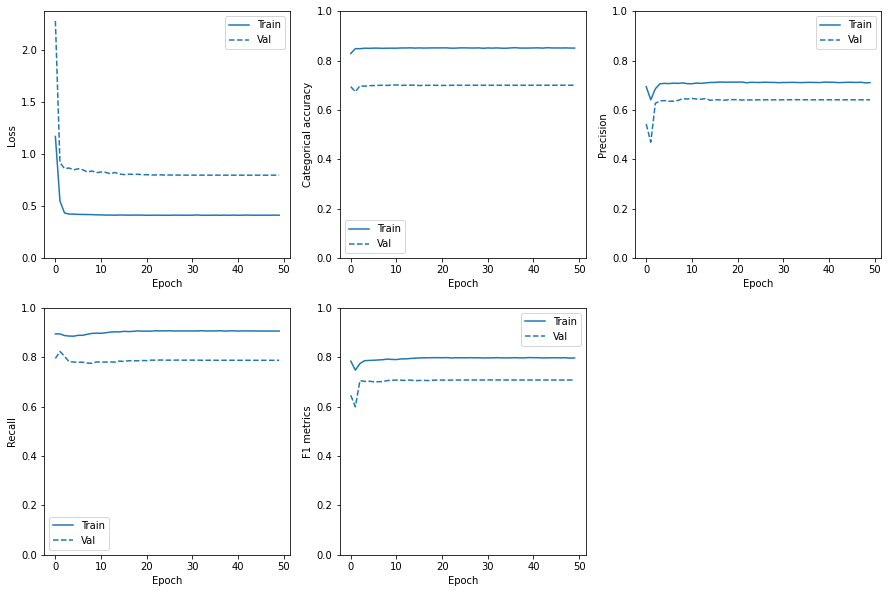

In [23]:
plot_metrics(history)

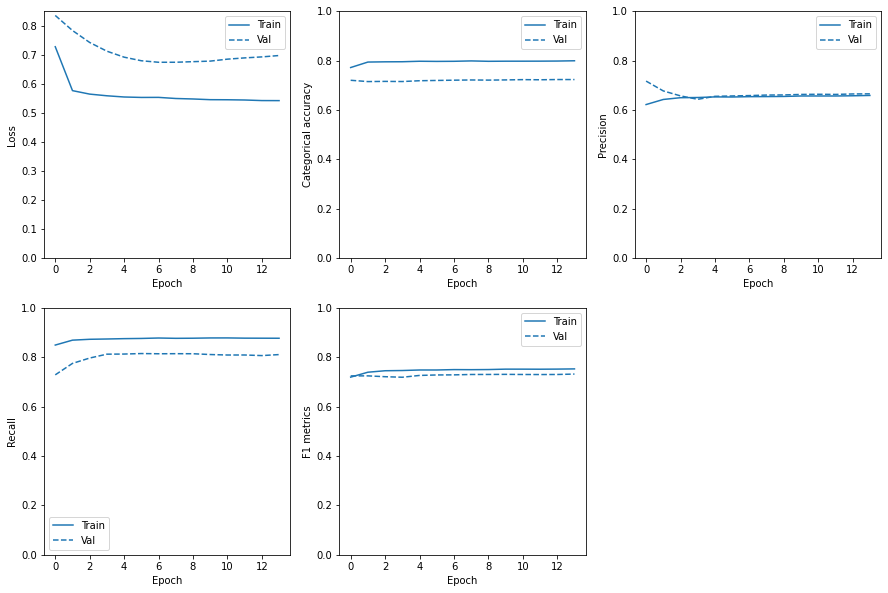

In [24]:
plot_metrics(history_stacked_lstm)

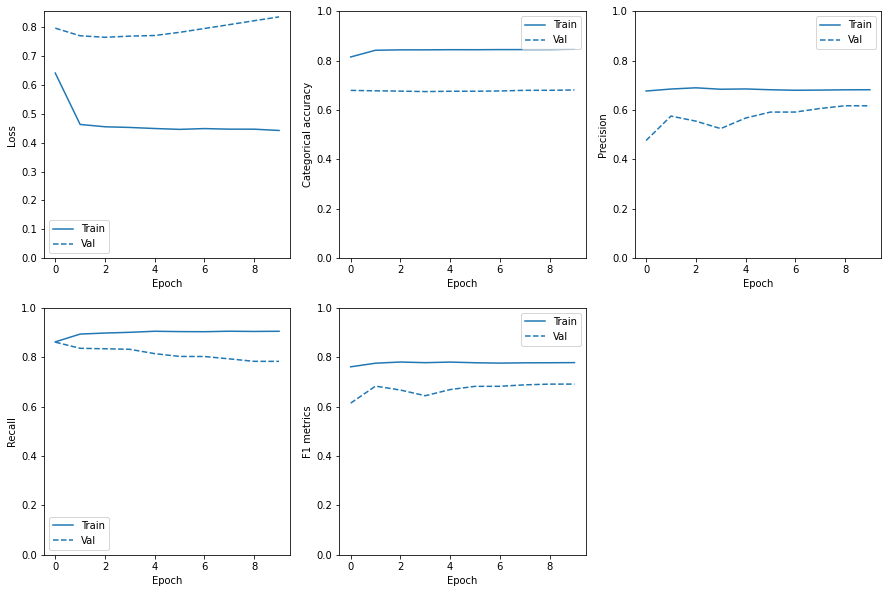

In [25]:
plot_metrics(history_stacked_cnn)

In [26]:
stack_model.evaluate(np.array(list(zip(*np.squeeze(test_predictions)))),y_test_cat)

357/357 [==============================] - 1s 3ms/step - loss: 0.8161 - categorical_accuracy: 0.6923 - precision: 0.6346 - recall: 0.7797 - f1_metrics: 0.7000


[0.8161458373069763,
 0.6923481225967407,
 0.6346468925476074,
 0.7797233462333679,
 0.7000247240066528]

In [27]:
stacked_model_lstm.evaluate(np.array(list(zip(*np.squeeze(test_lstm_predictions)))),y_test_cat)

357/357 [==============================] - 1s 3ms/step - loss: 0.6976 - categorical_accuracy: 0.7190 - precision: 0.6626 - recall: 0.8087 - f1_metrics: 0.7288


[0.6975862979888916,
 0.7189633846282959,
 0.6626255512237549,
 0.8087025284767151,
 0.7287685871124268]

In [28]:
stacked_model_cnn.evaluate(np.array(list(zip(*np.squeeze(test_cnn_predictions)))),y_test_cat)

357/357 [==============================] - 1s 3ms/step - loss: 0.8563 - categorical_accuracy: 0.6724 - precision: 0.6083 - recall: 0.7728 - f1_metrics: 0.6811


[0.8562695384025574,
 0.672386646270752,
 0.6082552075386047,
 0.7728068828582764,
 0.681106686592102]